<center> <h1>Using GraphWave </h1> </center>

&nbsp;

&nbsp;

The goal of the  following notebook is to show how the GraphWave algorithm can be used. 

GraphWave was implemented in Python 2.7 and requires to load the following Python packages:

+ __networkx__ (for handling network objects: in particular, visualization, etc.)
+ traditional libraries for data analytics: 
    + __seaborn__ for plotting
    + __pandas__ for dataframes
    + __sklearn__ for analytics


In [1]:
import sys
sys.path.append("./graphwave")

%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import graphwave
from graphwave.shapes import build_graph
from graphwave.graphwave import *


np.random.seed(123)


## I. Creating a graph

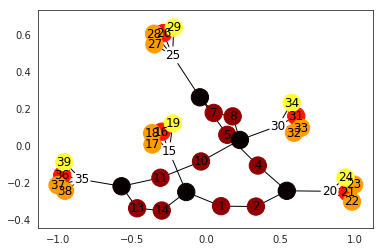

In [2]:
# 1- Start by defining our favorite regular structure

width_basis = 15
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 5  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [["house"]] * n_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
### ここを変更する(nx.Graphを作成する)
add_edges = 0
G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=True,
                                       savefig=False)

In [41]:
G = nx.DiGraph()

node_data = pd.read_csv("../../node_ids.txt")
edge_list = pd.read_csv("../../result.edgelist", delim_whitespace=True)

for node in node_data.iterrows():
  G.add_node(node[1]["id"])


for edge in edge_list.iterrows():
  G.add_edge(edge[1][0], edge[1][1])

(Note: best visualization of the graphs are obtained using Gephi, or some other specialized graph visualization software)

## II. Running GraphWave


We propose here a simple demonstration of GraphWave using both the automatic version (part a) and the manual version. This shows how to use GraphWave in a parameter-free version, or giving the analyst the possibility to select an adequate scale value.

For each of these approaches, we compute the signature by calling GraphWave. We then compute its PCA projection to visualize the embeddings. Note that in this very simple examples, GraphWave recovers structura equivalence, as shown by the overlapping embeddings on the first principal components.

#### a. Multiscale GraphWave: Automatic selection of the range of scales

In [42]:
chi, heat_print, taus = graphwave_alg(G, np.linspace(0,100,25), taus='auto', verbose=True)

指定したノードに近接するノードを上から5つ取得

In [80]:
from scipy.spatial import distance

distances = distance.cdist(chi,chi,"cosine")

def get_similar_nodes(node_distances_index):
  sorted_distances_of_target_node = sorted(distances[node_distances_index], reverse=True)
  print "対象ノード: id={0}, name={1}".format(node_data.loc[node_distances_index]["id"], node_data.loc[node_distances_index]["name"])
  for i in range(5):
    n_th_similar_node_index = np.where(distances[node_distances_index] == sorted_distances_of_target_node[i])[0][0]
    print "{0}位: id={1}, name={2}".format(i+1, node_data.loc[n_th_similar_node_index]["id"],node_data.loc[n_th_similar_node_index]["name"])

get_similar_nodes(1)

対象ノード: id=1, name=vs/base/common/errors
1位: id=3, name=vs/base/common/lifecycle
2位: id=2301, name=vs/workbench/contrib/localHistory/browser/localHistoryFileSystemProvider
3位: id=2320, name=vs/workbench/contrib/markers/browser/markersView
4位: id=2317, name=vs/workbench/contrib/markers/browser/markers
5位: id=282, name=vs/base/test/common/filters


We now visualize the resulting embeddings by computing their PCA projections. We also run KMeans to assess how well the signatures that we have here generated enable the recovery of structural roles.

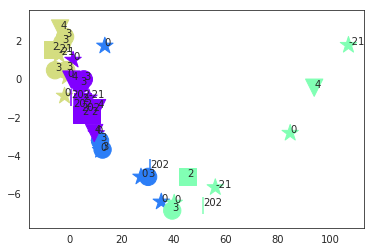

In [28]:
nb_clust = len(np.unique(role_id))
pca = PCA(n_components=5)
trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
km = KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_

######## Params for plotting
cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,nb_clust+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}

for c in np.unique(role_id):
    indc = [i for i,x in enumerate(role_id) if x==c]
    plt.scatter(trans_data[indc,0], trans_data[indc,1],
                c=np.array(col)[list(np.array(labels_pred)[indc])],
                marker=markers[c%len(markers)], s=300)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

#### Uniscale GraphWave: Hand-selected value for tau

In [29]:
np.linspace(0,10,100)

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [30]:
### Select a scale of interest (here we select a particular range of scale. See associated paper for 
### guidelines on how to select the appropriate scale.)

### Compute the heat wavelet
from graphwave.graphwave import *

time_pts = list(np.arange(0,50,0.5))
chi,heat_print, taus=graphwave_alg(G, np.linspace(0,10,100), taus=[1.0], verbose=True) 
print(chi.shape, len(time_pts))

((3207, 200), 100)


Note that in the EPFL implementation, by construction, the wavelet scales are all divided by the maximum eigenvalue $\lambda_N$.

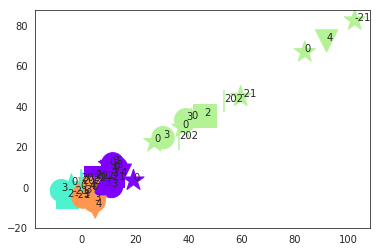

In [31]:
nb_clust=len(np.unique(role_id))
pca=PCA(n_components=5)
trans_data=pca.fit_transform(StandardScaler().fit_transform(chi))
km=KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_


cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,np.max(labels_pred)+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}


for c in np.unique(role_id):
        indc=[i for i,x in enumerate(role_id) if x==c]
        _ = plt.scatter(trans_data[indc,0], trans_data[indc,1],c=np.array(col)[list(np.array(labels_pred)[indc])] ,marker=markers[c%len(markers)],s=500)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            _ = plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

## III. Visualizing the Characteristic functions

We now propose to show how to visualize characteristic functions.


In [32]:
mapping = {u: i for i,u in enumerate(np.unique(role_id))}
cmap=plt.get_cmap('gnuplot')
role_id_plot=[cmap(x) for x in np.linspace(0,1,len(np.unique(role_id)))]
plt.figure()
ind_x=range(chi[0].shape[0])[0::2]
ind_y=range(chi[0].shape[0])[1::2]
for i in np.random.choice(range(G.number_of_nodes()),10,replace=False):
    _ = plt.plot(chi[i, ind_x],chi[i, ind_y],label=str(i),color=role_id_plot[mapping[role_id[i]]])

_ = plt.legend(loc='center left',bbox_to_anchor=(1,0.5))


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>